# Predicción de demanda de alquileres sitycleta por países

### En este trabajo final del curso de Inteligencia Artificial y Big data que estamos trabajandom, vamos a realizar la predicion de numero de usuarios de "sitycleta" de la empresa de Sagulpa.

En este trabajo lo que se pretende llevar a cabo es la creacíon y manipulación de datos optenidos por la empresa Sagulpa en su paguina web 

## Documentación

ID de cada Pais

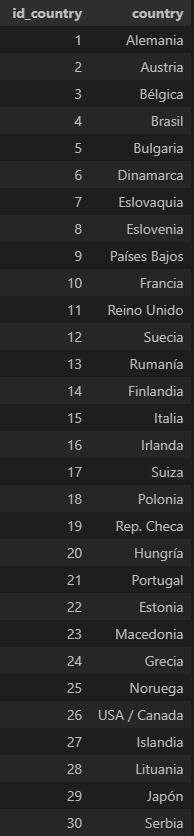

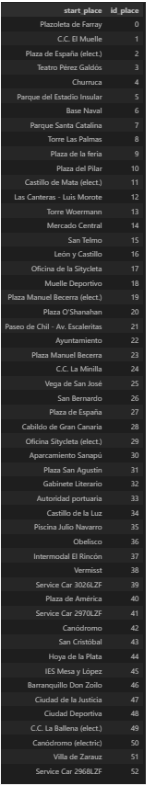

# Inicio del Proyecto

In [65]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle

Importamos los dataset con los que vamos a trabajar

In [66]:
df_clima = pd.read_csv('data/time_df.csv', sep=';')
df_sagulpa = pd.read_csv('data/sagulpa_df.csv', sep=';')

Asiganamos las columnas climatologicas a la de sagulpa teniendo en cunta el día 

In [67]:
# Renombrar las columnas en df_clima
nuevos_nombres = {' tmed': 'tmed', ' tmin': 'tmin', ' velmedia': 'velmedia'}
df_clima = df_clima.rename(columns=nuevos_nombres)

# Iterar sobre las filas de df_sagulpa
for index, row in df_sagulpa.iterrows():
    # Buscar una coincidencia en df_clima para el día actual
    match = df_clima[(df_clima['day'] == row['start_day'])]
    
    # Si se encontró una coincidencia
    if not match.empty:
        # Actualizar las columnas en df_sagulpa con los valores correspondientes de df_clima
        df_sagulpa.loc[index, 'prec'] = match.iloc[0]['prec']
        df_sagulpa.loc[index, 'presMax'] = match.iloc[0]['presMax']
        df_sagulpa.loc[index, 'presMin'] = match.iloc[0]['presMin']
        df_sagulpa.loc[index, 'tmax'] = match.iloc[0]['tmax']
        df_sagulpa.loc[index, 'tmed'] = match.iloc[0]['tmed']
        df_sagulpa.loc[index, 'tmin'] = match.iloc[0]['tmin']
        df_sagulpa.loc[index, 'velmedia'] = match.iloc[0]['velmedia']

Eliminamos columnas para preparar el DF_final

In [68]:
colum_delete = ['start_month','start_min', 'start_h', 'start_seg', 'end_day', 'end_month', 'end_h', 'end_min', 'end_seg', 'user_time', 'country']
df_final = df_sagulpa.drop(columns=colum_delete)
df_final

,id_country,start_place,start_day,prec,presMax,presMin,tmax,tmed,tmin,velmedia
0,18,Plazoleta de Farray,13,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10
1,20,C.C. El Muelle,2,1.10,1012.90,1008.80,23.00,20.70,18.40,3.30
2,14,Plaza de España (elect.),27,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70
3,11,Teatro Pérez Galdós,27,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70
4,11,Churruca,30,0.00,1022.10,1019.50,24.90,22.50,20.10,1.90
...,...,...,...,...,...,...,...,...,...,...
4279,18,San Telmo,28,0.00,1020.60,1018.10,23.20,21.80,20.50,1.10
4280,15,Plaza de la feria,13,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10
4281,11,Plazoleta de Farray,4,0.00,1007.70,1004.90,23.00,20.10,17.20,1.10
4282,14,Plaza de la feria,1,3.10,1015.70,1012.00,22.30,20.60,19.00,2.80


En este caso hemos borrado las columnas que eran de tipo String y las fecha y hora en la que el usurio dejo la bicicleta ya que para nuestro proyecto no las vamos a usar

In [69]:
# descargamos el df final de nuestro poryecto
df_final.to_csv('df_sagulpa.csv', index=False)

## Entrenamiento del modelo

### Primero vamos a separar los datos

In [70]:
# Contar el número de cogidas de bicicletas por base y dia
word = df_final.groupby(['start_place','start_day']).size().reset_index(name='catch_for_day')

# hacemos una muestra buscando por el nombre de una base
word[word['start_place'] == 'C.C. El Muelle']

,start_place,start_day,catch_for_day
83,C.C. El Muelle,1,3
84,C.C. El Muelle,2,5
85,C.C. El Muelle,3,1
86,C.C. El Muelle,4,5
87,C.C. El Muelle,5,6
88,C.C. El Muelle,6,6
89,C.C. El Muelle,7,4
90,C.C. El Muelle,8,5
91,C.C. El Muelle,10,7
92,C.C. El Muelle,11,12


In [71]:
# Realizar la fusión basada en la columna 'start_place' y 'start_day'
df_final = df_final.merge(word, on=['start_place', 'start_day'], how='left')

# Obtener los códigos numéricos y los valores únicos correspondientes
codes, unique_values = pd.factorize(df_final['start_place'])

# Agregar una nueva columna con los códigos numéricos
df_final['id_place'] = codes

In [72]:
# Creamos un nuevo DataFrame con los valores únicos de 'start_place' e 'id_place'
unique_values = df_final[['start_place', 'id_place']].drop_duplicates()
unique_values

,start_place,id_place
0,Plazoleta de Farray,0
1,C.C. El Muelle,1
2,Plaza de España (elect.),2
3,Teatro Pérez Galdós,3
4,Churruca,4
5,Parque del Estadio Insular,5
6,Base Naval,6
7,Parque Santa Catalina,7
15,Torre Las Palmas,8
16,Plaza de la feria,9


In [73]:
# eliminamos la columna string de nombres de base
df_final = df_final.drop('start_place', axis=1)

# renombrar el nombre de las columnas
df_final.rename(columns={'start_day': 'day'}, inplace=True)

# Columnas que contienen valores enteros
columnas_enteros = ['id_country', 'day', 'catch_for_day', 'id_place']

# Convertir los valores enteros a valores de punto flotante
df_final[columnas_enteros] = df_final[columnas_enteros].astype(float)

# # mostramos el df
# df_final

In [74]:
df_final

,id_country,day,prec,presMax,presMin,tmax,tmed,tmin,velmedia,catch_for_day,id_place
0,18.00,13.00,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10,9.00,0.00
1,20.00,2.00,1.10,1012.90,1008.80,23.00,20.70,18.40,3.30,5.00,1.00
2,14.00,27.00,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70,8.00,2.00
3,11.00,27.00,0.00,1019.70,1012.00,22.50,21.10,19.70,4.70,6.00,3.00
4,11.00,30.00,0.00,1022.10,1019.50,24.90,22.50,20.10,1.90,13.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...
4279,18.00,28.00,0.00,1020.60,1018.10,23.20,21.80,20.50,1.10,16.00,15.00
4280,15.00,13.00,0.00,1017.20,1015.00,25.00,22.20,19.40,1.10,5.00,9.00
4281,11.00,4.00,0.00,1007.70,1004.90,23.00,20.10,17.20,1.10,13.00,0.00
4282,14.00,1.00,3.10,1015.70,1012.00,22.30,20.60,19.00,2.80,7.00,9.00


[Text(0.5, 0, 'id_country'),
 Text(1.5, 0, 'day'),
 Text(2.5, 0, 'prec'),
 Text(3.5, 0, 'presMax'),
 Text(4.5, 0, 'presMin'),
 Text(5.5, 0, 'tmax'),
 Text(6.5, 0, 'tmed'),
 Text(7.5, 0, 'tmin'),
 Text(8.5, 0, 'velmedia'),
 Text(9.5, 0, 'catch_for_day'),
 Text(10.5, 0, 'id_place')]

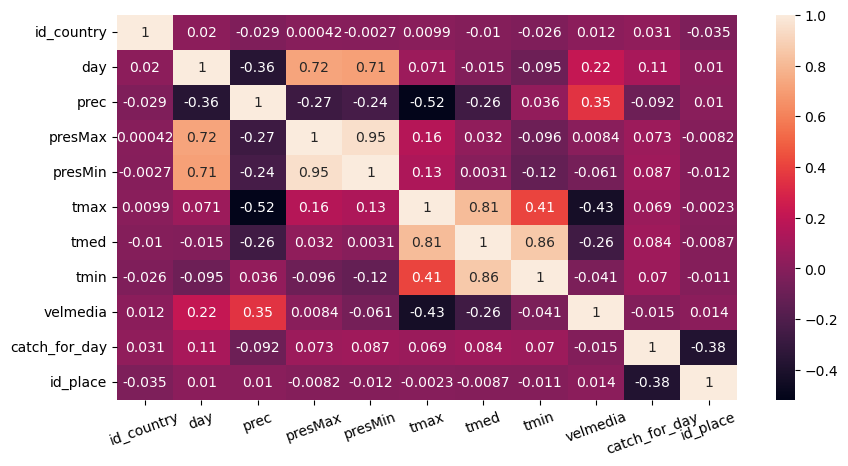

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.heatmap(df_final.corr(), annot=True)

# Ajustar las etiquetas del eje x en horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

## Dividimos los datos para el Entrenamiento

In [76]:
# Dividimos los datos de entrenamiento
X_Train  = df_final.drop(['catch_for_day'], axis=1)
Y_Train  = df_final['catch_for_day']

# train y test
x_train, x_test, y_train, y_test = train_test_split(X_Train, Y_Train, test_size=0.4, random_state=42)

### Segundo realizamos con el LazyPredict un estudio rapido sobre que modelos nos puede servir para el entrenamiento

In [77]:
# Inicialización de LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

# Entrenamiento y evaluación de los modelos
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

# Imprimir los modelos
models

100%|██████████| 42/42 [03:21<00:00,  4.81s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.93,0.93,1.00,0.66
RandomForestRegressor,0.92,0.92,1.12,1.08
XGBRegressor,0.90,0.91,1.19,0.22
BaggingRegressor,0.89,0.90,1.25,0.13
DecisionTreeRegressor,0.87,0.87,1.41,0.03
HistGradientBoostingRegressor,0.84,0.84,1.57,1.06
LGBMRegressor,0.83,0.84,1.57,0.12
ExtraTreeRegressor,0.82,0.83,1.62,0.02
GradientBoostingRegressor,0.61,0.61,2.41,0.33


In [78]:
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

cv = TimeSeriesSplit(n_splits = 10)
X_Train.reset_index(drop=True,inplace=True)

total_scores = []
for estimators in l_estimators:
    fold_accuracy = []
    regressor = RandomForestRegressor(n_estimators= estimators, criterion='absolute_error')
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(X_Train):
      
      # División train test aleatoria
      f_train = X_Train.loc[train_fold]
      f_test = X_Train.loc[test_fold]
      
      # entrenamiento y ejecución del modelo
      regressor.fit(x_train, y_train)
      Y_Pred = regressor.predict(x_test)
      
      # evaluación del modelo
      mae = mean_absolute_error(y_test,Y_Pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(l_estimators, total_scores, marker='o')
print ('Min Value :' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
    
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 512, MAE =   0.56)


In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error')

# fit and predict
for train_fold, test_fold in cv.split(X_Train):
  
  # División train test aleatoria
  f_train = X_Train.loc[train_fold]
  f_test = X_Train.loc[test_fold]
  
  # entrenamiento y ejecución del modelo
  regressor.fit(x_train,y_train)

Y_Pred = regressor.predict(x_test)

In [ ]:
Y_Pred

array([ 6.62304688,  6.48046875,  4.71875   , ..., 10.765625  ,
        7.99609375, 10.98632812])

In [ ]:
mae = mean_absolute_error(y_test, Y_Pred)
print ("MAE = %6.2f"% (mae))

MAE =   0.56


In [ ]:
# Grabamos el modelo en el directorio
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(regressor, file)

In [ ]:
# Cargamos el modelo
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

Realizamos una prueba con nuestro modelo entrenado para ver que resultados nos da

In [ ]:
x_in = np.asarray([23,13,0.0,1017.2,1015,25,22,19.4,1.1,7]).reshape(1,-1)
predicts = model.predict(x_in)
predicts[0]

13.970703125

In [ ]:
for i in range(1, 31):
    x_in = np.asarray([i, 24, 0.0, 1017.2, 1015, 25, 22, 19.4, 1.1, 7]).reshape(1, -1)
    predicts = model.predict(x_in)
    print(f"Predicción para i={i}: {predicts[0]}")

Predicción para i=1: 13.802734375
Predicción para i=2: 13.755859375
Predicción para i=3: 13.744140625
Predicción para i=4: 13.720703125
Predicción para i=5: 13.74609375
Predicción para i=6: 13.7890625
Predicción para i=7: 13.802734375
Predicción para i=8: 13.802734375
Predicción para i=9: 13.83203125
Predicción para i=10: 13.771484375
Predicción para i=11: 13.7890625
Predicción para i=12: 13.775390625
Predicción para i=13: 13.685546875
Predicción para i=14: 13.52734375
Predicción para i=15: 13.5078125
Predicción para i=16: 13.521484375
Predicción para i=17: 13.701171875
Predicción para i=18: 13.796875
Predicción para i=19: 13.849609375
Predicción para i=20: 13.771484375
Predicción para i=21: 13.16796875
Predicción para i=22: 13.146484375
Predicción para i=23: 13.177734375
Predicción para i=24: 13.69140625
Predicción para i=25: 13.69140625
Predicción para i=26: 13.703125
Predicción para i=27: 13.703125
Predicción para i=28: 13.703125
Predicción para i=29: 13.708984375
Predicción para i=